In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from lime.lime_text import LimeTextExplainer
import nltk
from nltk.corpus import stopwords
import re

# Daten laden
df = pd.read_csv('HatespeechDataset.csv')

# Textvorverarbeitung
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['Content_clean'] = df['Content'].apply(clean_text)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    df['Content_clean'], 
    df['Label'], 
    test_size=0.2, 
    random_state=42
)

# TF-IDF Vektorisierung
vectorizer = TfidfVectorizer( #sparen von Ressourcen, deswegen die inits; dimension vektorraum reduzieren
    max_features=5000,
    min_df=5,
    max_df=0.7,
    stop_words='english'
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# SVM mit RBF Kernel (nicht-linear und nicht direkt interpretierbar)
model = SVC(kernel='rbf', probability=True, random_state=42)
model.fit(X_train_tfidf, y_train)

# Modellevaluierung
print('Train Accuracy:', model.score(X_train_tfidf, y_train))
print('Test Accuracy:', model.score(X_test_tfidf, y_test))


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
import joblib

# Modell speichern!
joblib.dump(model, 'hate_speech_svm.joblib')

joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

import pickle
split_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'X_train_tfidf': X_train_tfidf,
    'X_test_tfidf': X_test_tfidf
}

with open('train_test_split.pkl', 'wb') as f:
    pickle.dump(split_data, f)

print("Modell und Daten wurden gespeichert!")

Modell und Daten wurden gespeichert!




Original Text: motherfucker
Prediction: Hate Speech
Probabilities: Normal Speech: 0.080, Hate Speech: 0.920

Feature Importance:
motherfucker                   : +0.321


<Figure size 1000x400 with 0 Axes>

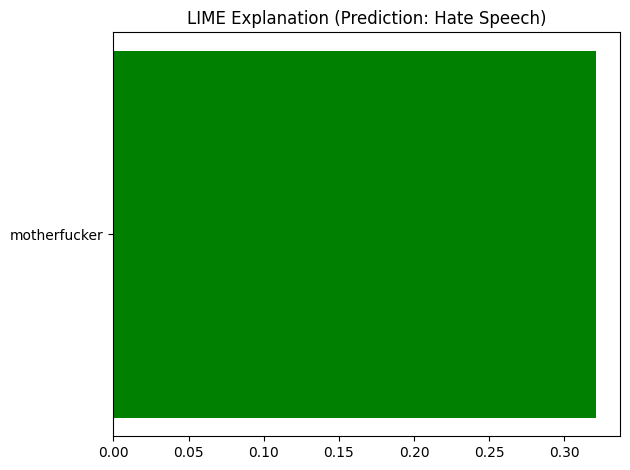



Original Text: denial of normal the con be asked to comment on tragedies an emotional retard
Prediction: Hate Speech
Probabilities: Normal Speech: 0.080, Hate Speech: 0.920

Feature Importance:
retard                         : +0.790
denial                         : -0.025
comment                        : +0.016
normal                         : +0.013
asked                          : -0.004
emotional                      : +0.003


<Figure size 1000x400 with 0 Axes>

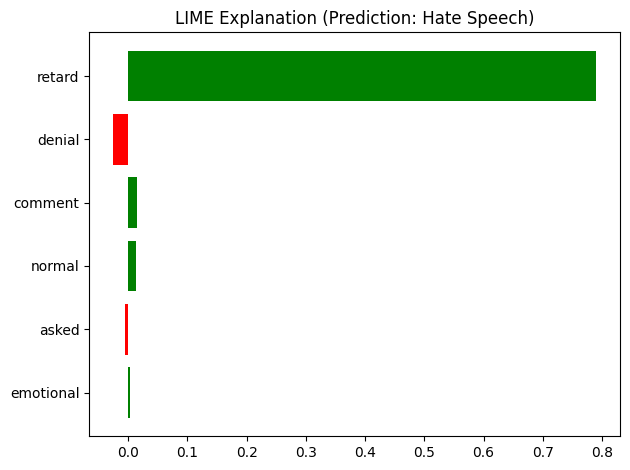



Original Text: suck my dick you mf
Prediction: Hate Speech
Probabilities: Normal Speech: 0.080, Hate Speech: 0.920

Feature Importance:
suck                           : +0.415
dick                           : +0.220
you                            : +0.032
my                             : +0.032
mf                             : +0.024


<Figure size 1000x400 with 0 Axes>

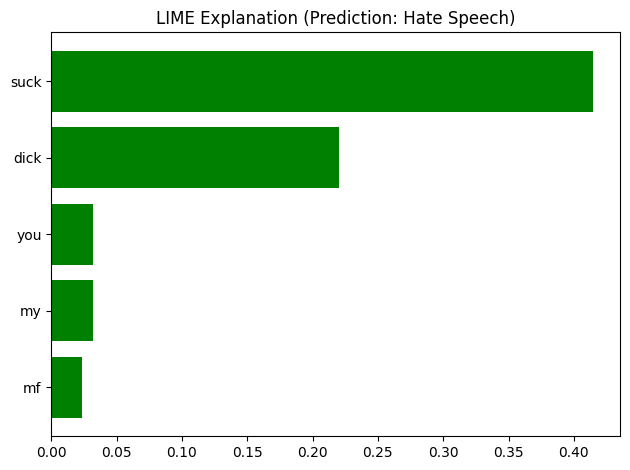



Original Text: you're a dumb retard
Prediction: Hate Speech
Probabilities: Normal Speech: 0.010, Hate Speech: 0.990

Feature Importance:
retard                         : +0.443
dumb                           : +0.246
a                              : +0.035
youre                          : -0.012


<Figure size 1000x400 with 0 Axes>

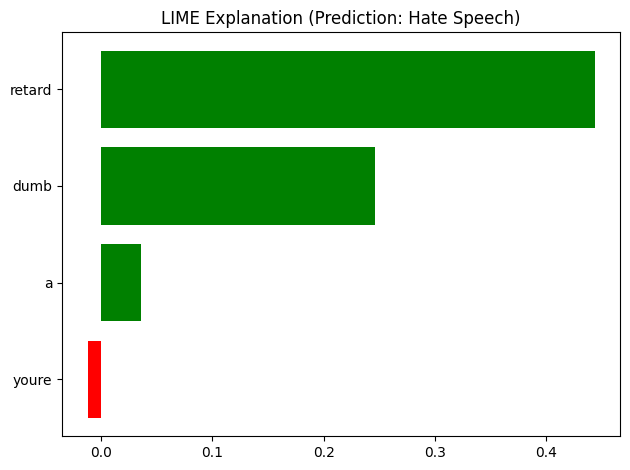



Original Text: you're such a stupid bitch its blowing my mind how brainrotted you are
Prediction: Hate Speech
Probabilities: Normal Speech: 0.472, Hate Speech: 0.528

Feature Importance:
stupid                         : +0.488
blowing                        : -0.069
mind                           : -0.063
bitch                          : -0.053
youre                          : +0.022
its                            : +0.002


<Figure size 1000x400 with 0 Axes>

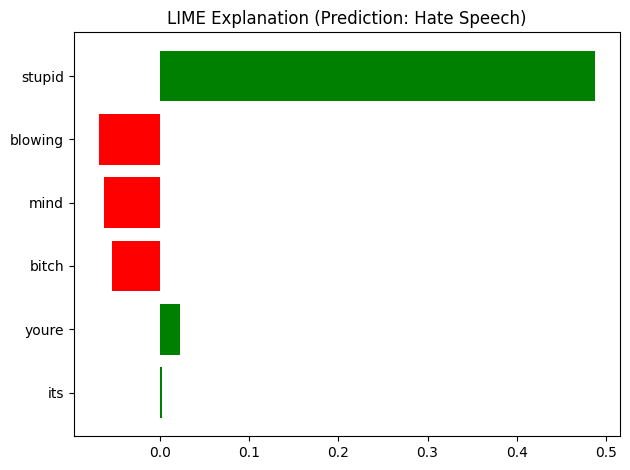



Original Text: lets hold hands and cuddle
Prediction: Normal Speech
Probabilities: Normal Speech: 0.962, Hate Speech: 0.038

Feature Importance:
hold                           : -0.053
hands                          : +0.008
lets                           : -0.001
and                            : -0.000
cuddle                         : -0.000


<Figure size 1000x400 with 0 Axes>

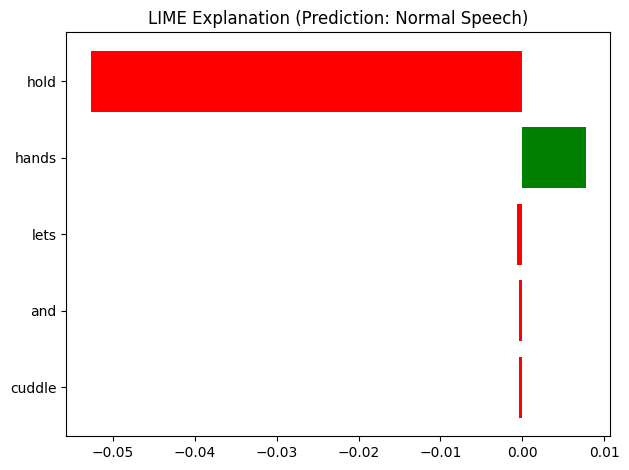



Original Text: let's go to the park
Prediction: Normal Speech
Probabilities: Normal Speech: 0.913, Hate Speech: 0.087

Feature Importance:
park                           : -0.000
lets                           : +0.000
go                             : +0.000
the                            : +0.000
to                             : +0.000


<Figure size 1000x400 with 0 Axes>

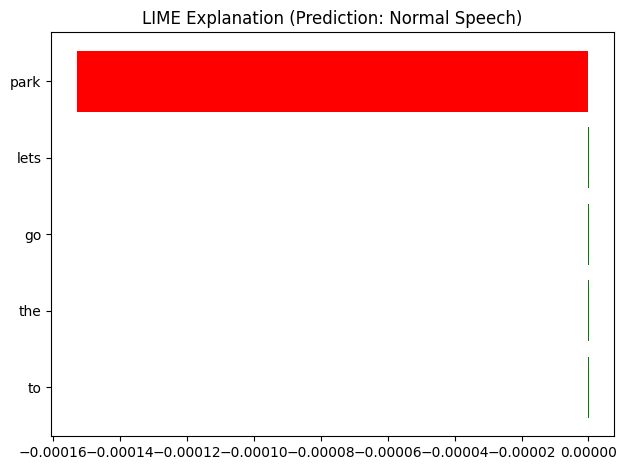

In [ ]:
import joblib
import pickle
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
import re

import lime
model = joblib.load('hate_speech_svm.joblib')
vectorizer = joblib.load('tfidf_vectorizer.joblib')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# LIME Explainer Erstellen
class_names = ['Normal Speech', 'Hate Speech']
explainer = LimeTextExplainer(class_names=class_names)

def predict_proba(texts):
    if isinstance(texts, str):
        texts = [texts]
    texts = [clean_text(text) for text in texts]
    vectors = vectorizer.transform(texts)
    return model.predict_proba(vectors)

def explain_text(text, num_features=6, show_plot=True):
  
    cleaned_text = clean_text(text)

    # LIME explanation bekommen; https://github.com/marcotcr/lime
    exp = explainer.explain_instance(
        cleaned_text,
        predict_proba,
        num_features=num_features,
        top_labels=2#beide Klassen anzeigen
    )
    
    # wahrscheinlichkeiten
    probs = predict_proba([cleaned_text])[0]
    pred_class = "Hate Speech" if probs[1] > 0.5 else "Normal Speech"
    
    # ergebnisse
    print(f"Original Text: {text}")
    print(f"Prediction: {pred_class}")
    print(f"Probabilities: Normal Speech: {probs[0]:.3f}, Hate Speech: {probs[1]:.3f}")
    print("\nFeature Importance:")
    

    try:
        explanation = exp.as_list(label=1)
        for feature, weight in explanation:
            sign = "+" if weight > 0 else ""
            print(f"{feature:30} : {sign}{weight:.3f}")
        
        if show_plot:
            plt.figure(figsize=(10, 4))
            exp.as_pyplot_figure(label=1)
            plt.title(f"LIME Explanation (Prediction: {pred_class})")
            plt.tight_layout()
            plt.show()
    except:
        print("Konnte keine Erklärung für diesen Text generieren.")
    
    return exp

# Test Beispiele
test_texts = [
    
    "motherfucker",
    "denial of normal the con be asked to comment on tragedies an emotional retard",
    "suck my dick you mf",
    "you're a dumb retard",
    "you're such a stupid bitch its blowing my mind how brainrotted you are",
    "lets hold hands and cuddle",
    "let's go to the park"

    
    #"i love you",
    #"let's go to the park",
    #"motherfucker",
    
    
    #"just by being able to tweet this insufferable bullshit proves trump a nazi you vagina",
    
    
    #"get out of my face you braindead parasite"
    #"son of a bitch",
    #"migrants should leave the country",
    #"you are a social parasite",
    #"i am a kind person",
    #"you're very cute",
    #"trump should win the election",
    #"dumb trump should win the election",




   

   # "I'm so tired of this weather, it's always raining.",
   # "You're an amazing person, I'm so grateful to have you in my life.",
    #"This new policy is ridiculous, it's going to hurt so many people.",
    #"I love how diverse this city is, it's so enriching.",
    #"The food at this restaurant is disgusting, never coming back."
    #"You are a wonderful person and I appreciate your help!",
    #"I hate all people who look different than me, they should die!",
    #"The weather is nice today, let's go for a walk",
    #"You stupid idiot, go kill yourself",
    #"This movie was absolutely terrible, I want my money back"
    
    

]

# Einzelne Texte testen
for text in test_texts:
    print("\n" + "="*80 + "\n")
    explain_text(text)
    plt.close('all')  # Clean up plots



Original Text: try me
Prediction: Normal Speech
Probabilities: Normal Speech: 0.913, Hate Speech: 0.087

Feature Importance:
try                            : -0.000
me                             : +0.000


<Figure size 1000x400 with 0 Axes>

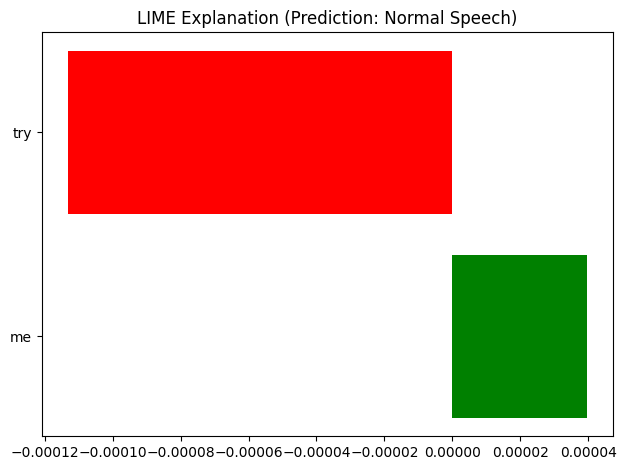

In [4]:
    
# Test Beispiele
test_texts = [

    "try me"

]

# Einzelne Texte testen
for text in test_texts:
    print("\n" + "="*80 + "\n")
    explain_text(text)
    plt.close('all')